<a href="https://colab.research.google.com/github/julienVLNT/python-sandbox/blob/main/machine%20learning/rl_01_tensorflow_deep_QNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


**Julien VALENTIN**, **avril 2022** d'après le tutoriel Tensorflow

> https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

---

Un `QAgent` est représenté par un réseau de neurones `QNetwork` : modèle de réseau de neurones séquentiel à couches denses pouvant apprendre un nombre fini de valeurs (les rendements attendus), associées à chaque action.

### Installation des dépendances

In [2]:
%%bash
sudo apt-get update
sudo apt-get install -y xvfb ffmpeg freeglut3-dev
pip install 'imgaug<2.7.0'
pip install 'imageio==2.4.0'
pip install pyvirtualdisplay
pip install tf-agents[reverb]
pip install pyglet

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-driver

### Import

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

### Initialisation d'un affichage virtuel

In [4]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

### Paramétrage de la simulation

In [5]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### Chargement de l'environnement `CartPole` depuis l'outil `OpenAI Gym`

In [6]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

On peut afficher sa situation initiale.

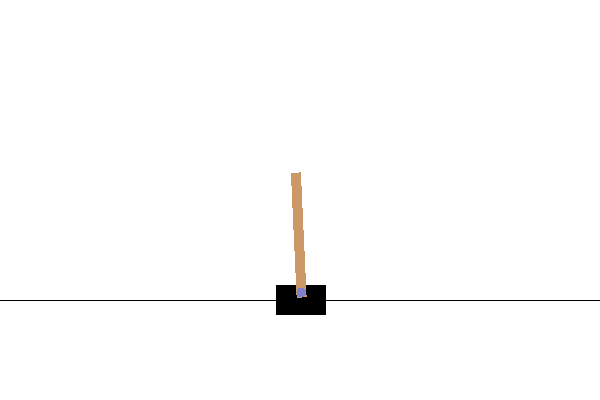

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

L'exécution d'une action se fait à l'aide de la méthode `environment.step(a)` prenant en paramètre une action `a` et retournant un objet `TimeStep` contenant
- la prochaine observation `environment.time_step_spec().observation`
- la récompense de l'action effectuée `a` `environment.time_step_spec().reward`

In [8]:
print(env.time_step_spec().observation)

BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [9]:
print(env.time_step_spec().reward)

ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


D'autre part, les actions permises depuis l'état `state` courant sont accessibles depuis la méthode `environment.action_spec()`

In [10]:
print(env.action_spec())

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


Par exemple, la politique de choix aléatoire s'obtiendrait par un tirage aléatoire sur la liste `[minimum, maximum]`. En fait, l'environnement `CartPole` se décline ainsi

> `observation` est un tableau de quatre nombres réels contenant la position et la vitesse du chariot d'une part et la vitesse angulaire et la position du sommet d'autre part.

> `reward` est un nombre réel scalaire

> `action` est un nombre entier : $0$ ou $1$, respectivement *déplacer vers la gauche* et *déplacer vers la droite*.

### Impact d'un déplacement vers la droite : `action = np.array(1, dtype=np.int32)`

In [11]:
time_step = env.reset()
print('time step:')
print(10*"-")
print(time_step)
print()

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(15*"-")
print(next_time_step)

time step:
----------
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.03325634,  0.02344959,  0.02523835, -0.03136761], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

Next time step:
---------------
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.03278735,  0.21820068,  0.02461099, -0.31598195], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


### `train test splitting`

In [12]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Implémentation d'un objet `QNetwork`

C'est le réseau de neurones qui permet l'évaluation des fonctions valeurs des états et des actions sous une politique $\pi$. 

In [13]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Fonction permettant de générer une couche dense de num_units neurones
# générique : chaque couche est initialisée par cette fonction.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# Implémentation du QNetwork.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

### Implémentation du `QAgent`

Conformément au formalisme vu précédemment, un agent est un objet composé de 

- un `QNetwork` permettant d'évaluer ce qu'il y a à évaluer,
- un `TimeSpec` rendu par l'environnement et qui correspond à ses capteurs d'informations (observation, récompense)
- une méthode d'optimisation pour la résolution
- une fonction de perte

Ces deux derniers objets servent à l'apprentissage de l'agent, à chaque épisode, l'agent a modifié les paramètres du `QNetwork`. L'apprentissage se fait par rétropropagation de l'erreur. On cherche à atteindre un minimum de la fonction de perte.

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

### Les stratégies, ou politiques

La tâche à accomplir est de maintenir le poteau droit sur le chariot. Une stratégie associe à chaque état (position et vitesse du chariot plus position du sommet du poteau et vitesse angulaire de celui-ci) une action : déplacer le poteau vers la gauche ou vers la droite. La stratégie affecte l'action à l'état à chaque date de la simulation.

Un agent possède deux stratégies : une première, `agent.policy`, utilisée pour l'entraînement et l'évaluation de l'agent ; la seconde, `agent.collect_policy`, utilisée pour la récolte de données.

**Stratégie de choix aléatoire**

On commence par essayer la stratégie de choix aléatoire : peu importe l'état, on choisit un déplacement par tirage selon la loi uniforme discrète.
- $\mathbb{P}(A=0|S) = \frac{1}{2}$
- $\mathbb{P}(A=1|S) = \frac{1}{2}$

quel que soit l'état $S$.

In [15]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

Pour obtenir l'action associée à un état, on appelle `policy.action(time_step)`. Son retour est un objet `PolicyStep` contenant

- `action`, ici `0` ou `1`
- `state`, l'état, utilisé pour les stratégies *stateful* ?
- `info`, métadonnées sur l'action rendue.

In [16]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

time_step = example_environment.reset()

random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

### Métrique et évaluation

In [17]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

D'autres métriques que le retour moyen existent. Plus d'informations sur

> https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

L'estimation de la performance de la stratégie aléatoire se fait en appelant la fonction précédente dans l'environnement de test.

In [18]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

23.7

### Histoire de la dynamique : les trajectoires, et le tampon de collecte de données

On peut garder en mémoire certaines données primordiales pour visualiser l'évolution des performances de l'algorithme sur le problème. En particulier, on stocke les tenseurs correspondants aux données de l'expérience.

In [19]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

En général, les informations pertinentes à garder son stockées dans un objet `Trajectory`, c.f exemple

In [20]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

Il se manipule comme un dictionnaire dont les entrées sont accessibles.

In [21]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [22]:
agent.collect_data_spec[0]

TensorSpec(shape=(), dtype=tf.int32, name='step_type')

### On effectue quelques boucles afin de récolter les données dans le tampon pour les inspecter

In [23]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.03859759, -0.01173052, -0.0402656 , -0.09064916], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)}),
 ())

In [24]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(
{'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>,
 'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.06404723, -0.38368443,  0.14418337,  0.9600658 ],
       [-0.07172092, -0.58041924,  0.16338469,  1.2943491 ]],
      dtype=float32)>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([308596924531348335, 308596924531348335], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dtype=fl

In [25]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None)))>

In [26]:
iterator = iter(dataset)

### Entraînement de l'agent

In [27]:
%%time
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 23.601720809936523
step = 400: loss = 10.51016616821289
step = 600: loss = 175.2891082763672
step = 800: loss = 1151.6298828125
step = 1000: loss = 26559.703125
step = 1000: Average Return = 26.899999618530273
step = 1200: loss = 120784.4609375
step = 1400: loss = 567972.25
step = 1600: loss = 1305213.0
step = 1800: loss = 5189801.5
step = 2000: loss = 4898877.0
step = 2000: Average Return = 176.5
step = 2200: loss = 34646640.0
step = 2400: loss = 6461748.5
step = 2600: loss = 21770346.0
step = 2800: loss = 32009656.0
step = 3000: loss = 41327376.0
step = 3000: Average Return = 126.69999694824219
step = 3200: loss = 24809388.0
step = 3400: loss = 45277044.0
step = 3600: loss = 68610864.0
step = 3800: loss = 36840872.0
step = 4000: loss =

### Visualisation

(0.1849997997283932, 250.0)

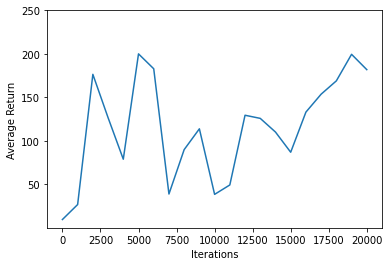

In [28]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [29]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [30]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [31]:
create_policy_eval_video(random_policy, "random-agent")